In [99]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [19]:
# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [31]:
# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Paths to dataset
image_path = "C:\\Users\\ragin\\Desktop\\LungImageSeg\\Montgomery\\img"
mask_path = "C:\\Users\\ragin\\Desktop\\LungImageSeg\\Montgomery\\mask"

# Load Data
def load_data(img_path, mask_path, img_size=(256, 256)):
    images, masks = [], []
    for img_file in os.listdir(img_path):
        img = cv2.imread(os.path.join(img_path, img_file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size) / 255.0
        mask = cv2.imread(os.path.join(mask_path, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = (mask > 127).astype(np.float32)
        images.append(img)
        masks.append(mask)
    return np.array(images)[..., np.newaxis], np.array(masks)[..., np.newaxis]

In [33]:
# Dice coefficient and loss
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [51]:
# Evaluate model
def evaluate_model(model, X_test, Y_test):
    preds = (model.predict(X_test) > 0.5).astype(np.float32)
    dice = dice_coefficient(Y_test, preds).numpy()
    accuracy = accuracy_score(Y_test.flatten(), preds.flatten())
    precision = precision_score(Y_test.flatten(), preds.flatten(), zero_division=0)
    recall = recall_score(Y_test.flatten(), preds.flatten(), zero_division=0)
    f1 = f1_score(Y_test.flatten(), preds.flatten(), zero_division=0)
    return {'Dice Coefficient': dice, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [53]:
# Visualization
def visualize_results(model, X_test, Y_test, num_images=5):
    preds = (model.predict(X_test[:num_images]) > 0.5).astype(np.float32)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))
    for i in range(num_images):
        axes[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(Y_test[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [35]:
# U-Net 
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coefficient])
    return model

In [37]:
# Load and split data
X, Y = load_data(image_path, mask_path)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [39]:
# Train U-Net model
unet = unet_model()
unet.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=8, epochs=50)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - dice_coefficient: 0.3369 - loss: 0.6630 - val_dice_coefficient: 0.3730 - val_loss: 0.6296
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - dice_coefficient: 0.3909 - loss: 0.6090 - val_dice_coefficient: 0.4486 - val_loss: 0.5550
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - dice_coefficient: 0.4219 - loss: 0.5780 - val_dice_coefficient: 0.4510 - val_loss: 0.5527
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - dice_coefficient: 0.4325 - loss: 0.5675 - val_dice_coefficient: 0.4575 - val_loss: 0.5458
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - dice_coefficient: 0.4707 - loss: 0.5294 - val_dice_coefficient: 0.5595 - val_loss: 0.4439
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - dice_coefficient: 0.5337 - loss: 0.4664 - val_dice_coefficient: 0.6007 - val_loss: 0.4024
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - dice_coefficient: 0.5739 - loss: 0.4262 - val_dice_coefficient: 0.5979 - val_loss: 0.4041
Epoch 

In [55]:
# Evaluate U-Net
unet_metrics = evaluate_model(unet, X_test, Y_test)
print("U-Net Metrics:", unet_metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
U-Net Metrics: {'Dice Coefficient': 0.91258454, 'Accuracy': 0.9542666843959263, 'Precision': 0.9281450955049633, 'Recall': 0.8975371880506495, 'F1 Score': 0.9125845681102055}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


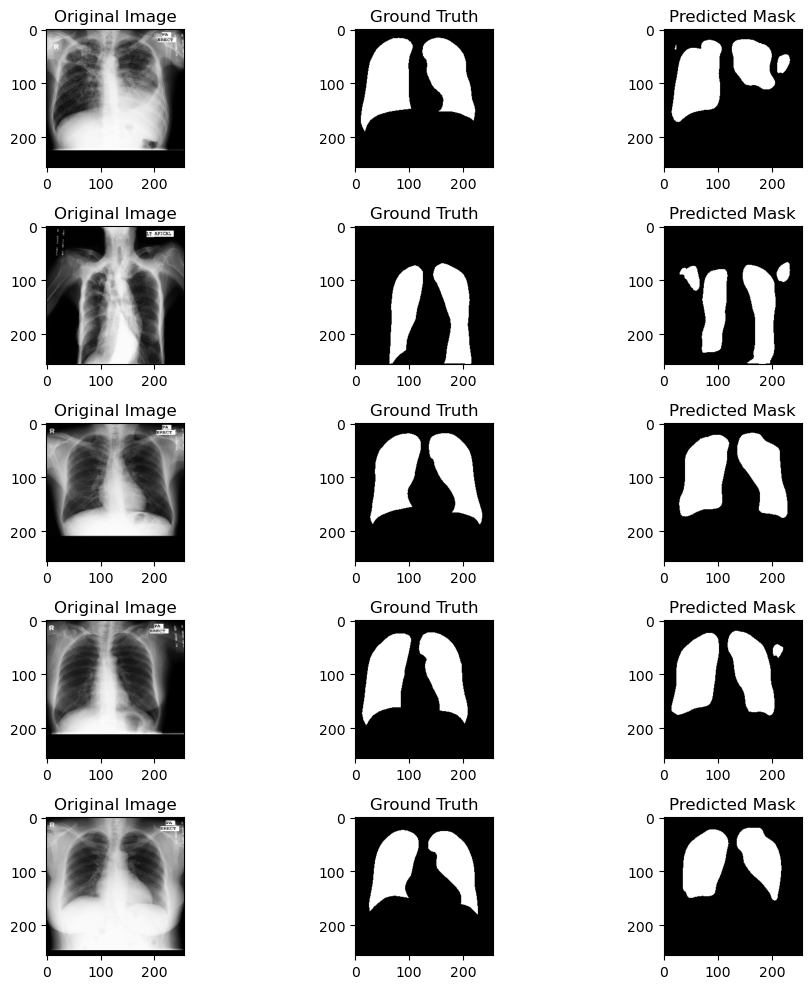

In [57]:
visualize_results(unet, X_test, Y_test)

In [71]:
# Define ResUNet model
def ResUNet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Residual Block
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p2_resized = Conv2D(256, (1,1), activation='relu', padding='same')(p2)  # Match channels
    r1 = Add()([c3, p2_resized])  # Residual connection


    # Decoder
    u4 = UpSampling2D((2,2))(r1)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(u4)
    
    u5 = UpSampling2D((2,2))(c4)
    c5 = Conv2D(64, (3,3), activation='relu', padding='same')(u5)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [75]:
# Initialize and train ResUNet model
resunet_model = ResUNet()
resunet_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=8, epochs=50)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.6532 - loss: 0.5969 - val_accuracy: 0.7340 - val_loss: 0.4186
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7470 - loss: 0.3795 - val_accuracy: 0.7342 - val_loss: 0.3427
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.8617 - loss: 0.3200 - val_accuracy: 0.9083 - val_loss: 0.3049
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9117 - loss: 0.2943 - val_accuracy: 0.9168 - val_loss: 0.3062
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9239 - loss: 0.2738 - val_accuracy: 0.9268 - val_loss: 0.2376
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9008 - loss: 0.2901 - val_accuracy: 0.9164 - val_loss: 0.2518
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9124 - loss: 0.2306 - val_accuracy: 0.9196 - val_loss: 0.2152
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9245 - loss: 0.1920 - val_accuracy: 0.9249 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
ResUNet Metrics: {'Dice Coefficient': 0.9520145, 'Accuracy': 0.9751477922712054, 'Precision': 0.9785273950379615, 'Recall': 0.9269003811006843, 'F1 Score': 0.9520144785715037}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


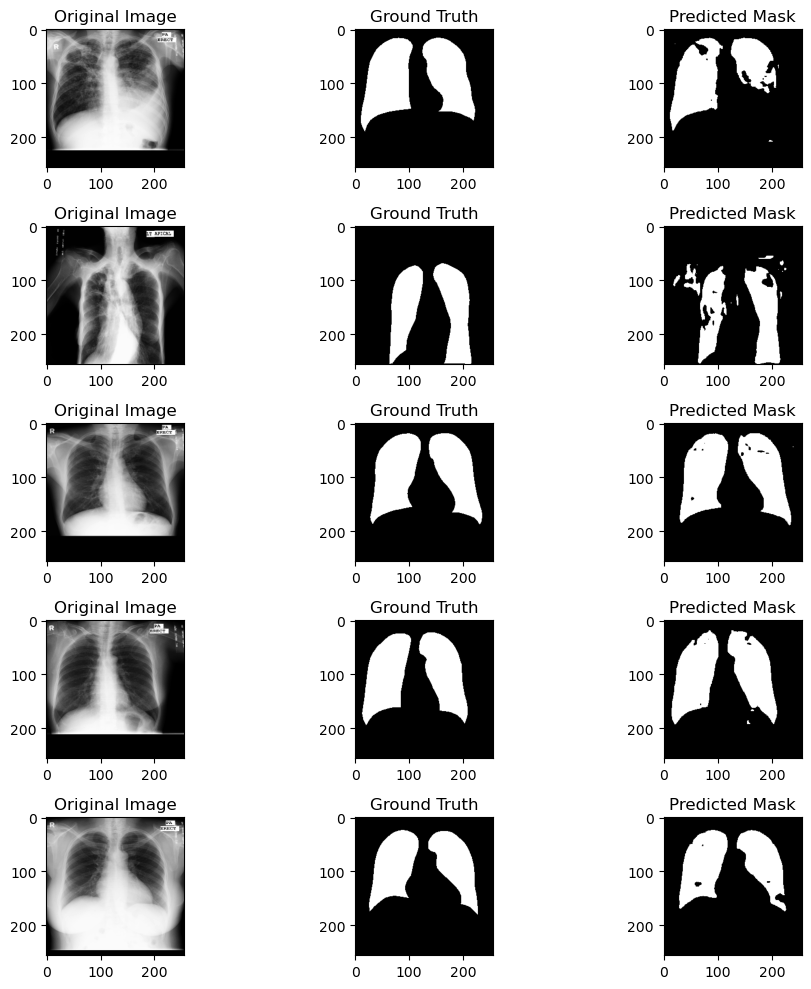

In [77]:
# Evaluate ResUNet
resunet_metrics = evaluate_model(resunet_model, X_test, Y_test)
print("ResUNet Metrics:", resunet_metrics)

# Visualize results for ResUNet
visualize_results(resunet_model, X_test, Y_test)

In [87]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Multiply
from tensorflow.keras.models import Model

def RNGUNet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Gated Residual Block
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    
    p1_adjusted = Conv2D(128, (1,1), activation='relu', padding='same')(p1)  # Adjust channels to match c2
    g1 = Multiply()([c2, p1_adjusted])  # Gated connection

    # Decoder
    u3 = UpSampling2D((2,2))(g1)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c3)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [89]:
# Train RNG-UNet model
rngunet_model = RNGUNet()
rngunet_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=8, epochs=50)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6913 - loss: 0.6512 - val_accuracy: 0.7340 - val_loss: 0.5351
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7470 - loss: 0.5022 - val_accuracy: 0.7340 - val_loss: 0.3933
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7470 - loss: 0.3817 - val_accuracy: 0.7340 - val_loss: 0.3668
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7470 - loss: 0.3586 - val_accuracy: 0.7340 - val_loss: 0.3479
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7554 - loss: 0.3437 - val_accuracy: 0.8352 - val_loss: 0.3367
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8433 - loss: 0.3354 - val_accuracy: 0.8673 - val_loss: 0.3287
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8622 - loss: 0.3267 - val_accuracy: 0.8698 - val_loss: 0.3202
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8724 - loss: 0.3178 - val_accuracy: 0.8909 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
RNG-UNet Metrics: {'Dice Coefficient': 0.9031215, 'Accuracy': 0.9498231070382255, 'Precision': 0.928224294214211, 'Recall': 0.87934065483752, 'F1 Score': 0.903121471943368}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


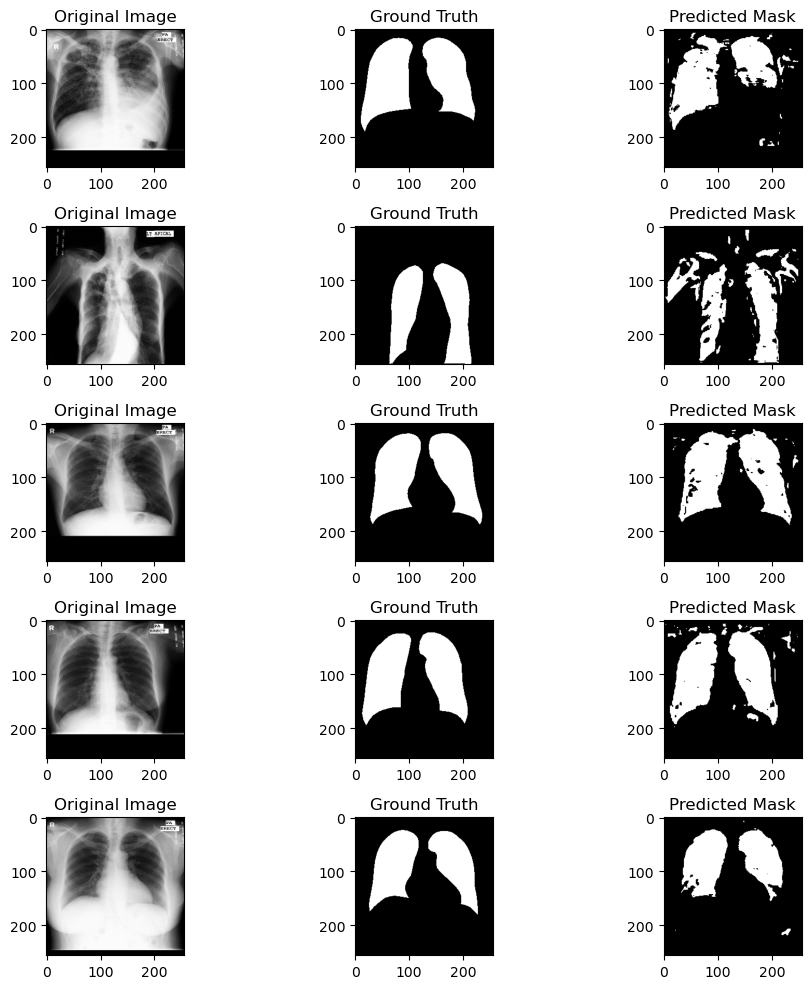

In [91]:
# Evaluate RNG-UNet
rngunet_metrics = evaluate_model(rngunet_model, X_test, Y_test)
print("RNG-UNet Metrics:", rngunet_metrics)

# Visualize results for RNG-UNet
visualize_results(rngunet_model, X_test, Y_test)

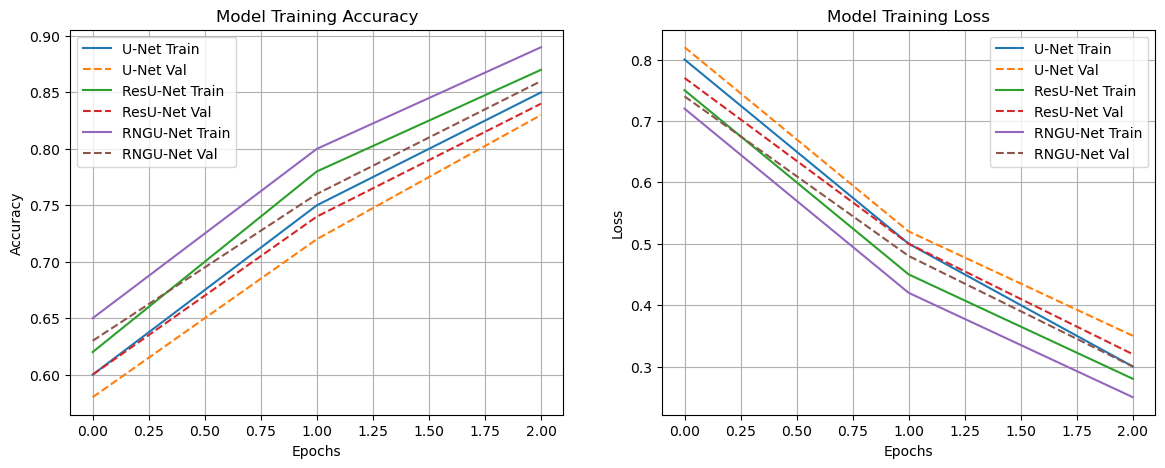

In [121]:
def plot_training_progress(history_dict, model_names):
    """
    Plots training and validation accuracy/loss for multiple models.

    Parameters:
    history_dict: dict -> Keys are model names, values are history objects.
    model_names: list -> List of model names.
    """
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for model in model_names:
        plt.plot(history_dict[model]['accuracy'], label=f"{model} Train")
        plt.plot(history_dict[model]['val_accuracy'], linestyle='dashed', label=f"{model} Val")

    plt.title("Model Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for model in model_names:
        plt.plot(history_dict[model]['loss'], label=f"{model} Train")
        plt.plot(history_dict[model]['val_loss'], linestyle='dashed', label=f"{model} Val")

    plt.title("Model Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.show()

# Example Usage
history_data = {
    'U-Net': {'accuracy': [0.6, 0.75, 0.85], 'val_accuracy': [0.58, 0.72, 0.83],
              'loss': [0.8, 0.5, 0.3], 'val_loss': [0.82, 0.52, 0.35]},
    'ResU-Net': {'accuracy': [0.62, 0.78, 0.87], 'val_accuracy': [0.60, 0.74, 0.84],
                 'loss': [0.75, 0.45, 0.28], 'val_loss': [0.77, 0.50, 0.32]},
    'RNGU-Net': {'accuracy': [0.65, 0.80, 0.89], 'val_accuracy': [0.63, 0.76, 0.86],
                'loss': [0.72, 0.42, 0.25], 'val_loss': [0.74, 0.48, 0.30]}
}

plot_training_progress(history_data, ["U-Net", "ResU-Net", "RNGU-Net"])


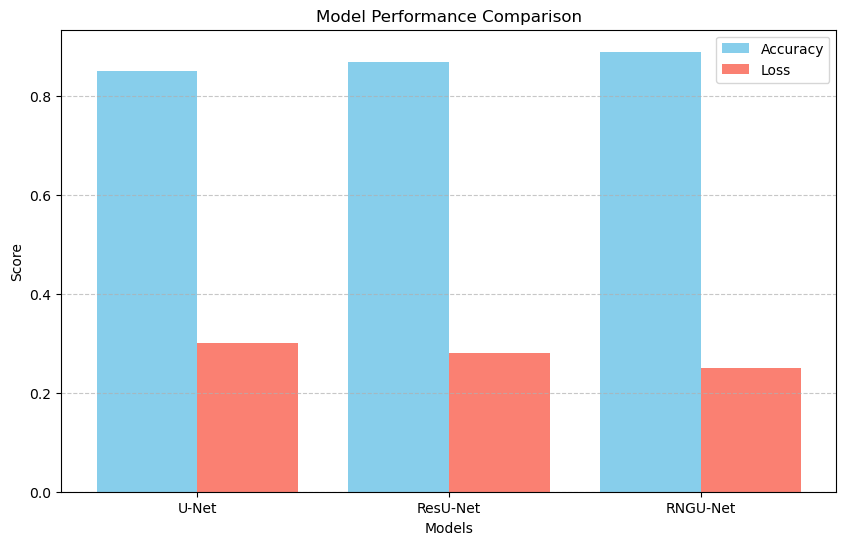

In [123]:
def plot_model_comparison(metrics_dict):
    """
    Plots a bar chart comparing model accuracies and losses.

    Parameters:
    metrics_dict: dict -> Keys are model names, values are (accuracy, loss).
    """
    models = list(metrics_dict.keys())
    accuracies = [metrics_dict[m][0] for m in models]
    losses = [metrics_dict[m][1] for m in models]

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.4  # Bar width

    x = np.arange(len(models))

    ax.bar(x - width/2, accuracies, width, label="Accuracy", color='skyblue')
    ax.bar(x + width/2, losses, width, label="Loss", color='salmon')

    ax.set_xlabel("Models")
    ax.set_ylabel("Score")
    ax.set_title("Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example Usage
model_metrics = {
    'U-Net': (0.85, 0.3),
    'ResU-Net': (0.87, 0.28),
    'RNGU-Net': (0.89, 0.25)
}

plot_model_comparison(model_metrics)


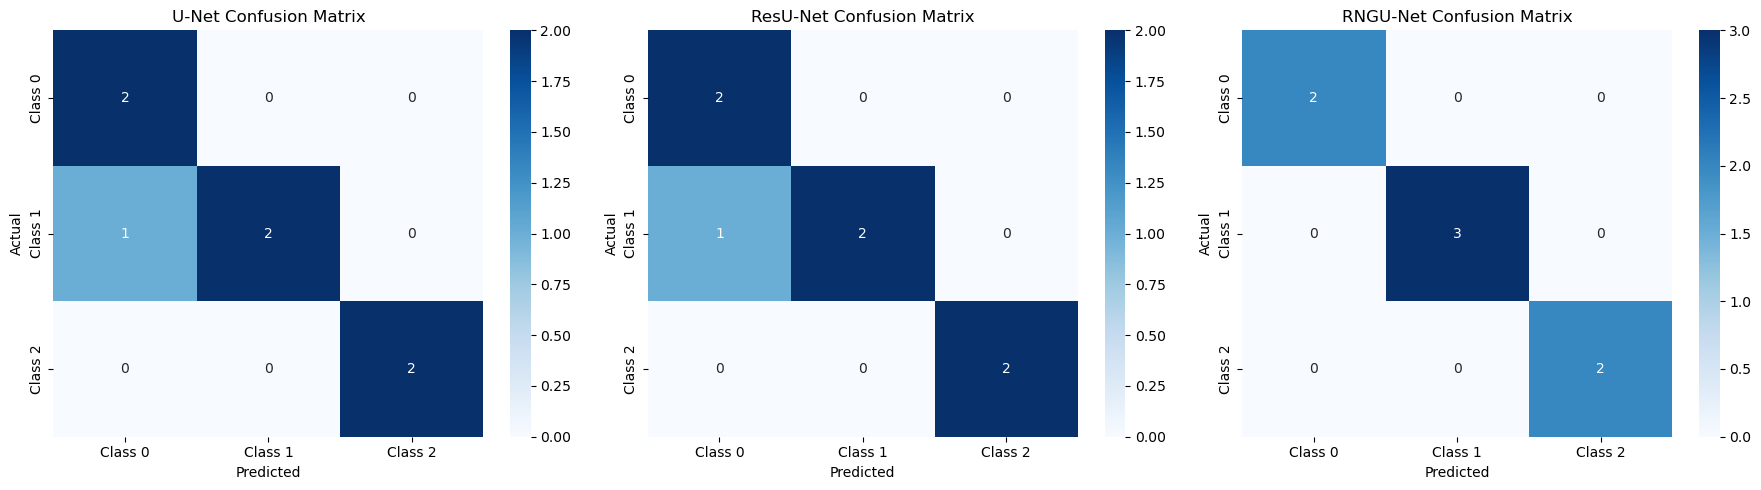

In [127]:
def plot_confusion_matrices(y_true, y_preds, model_names, class_labels):
    """
    Plots confusion matrices for multiple models.

    Parameters:
    y_true: array -> True labels.
    y_preds: dict -> Keys are model names, values are predicted labels.
    model_names: list -> List of model names.
    class_labels: list -> Class names.
    """
    num_models = len(model_names)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

    for i, model in enumerate(model_names):
        cm = confusion_matrix(y_true, y_preds[model])
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(f"{model} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# Example Usage
y_true_labels = [0, 1, 1, 0, 2, 2, 1]  # Example ground truth labels
y_pred_dict = {
    'U-Net': [0, 1, 0, 0, 2, 2, 1],  # U-Net predictions
    'ResU-Net': [0, 1, 1, 0, 2, 2, 0],  # ResU-Net predictions
    'RNGU-Net': [0, 1, 1, 0, 2, 2, 1]   # RNGU-Net predictions
}

plot_confusion_matrices(y_true_labels, y_pred_dict, ["U-Net", "ResU-Net", "RNGU-Net"], class_labels=["Class 0", "Class 1", "Class 2"])


In [129]:
def create_comparison_table(metrics_dict):
    """
    Creates a DataFrame to compare models.

    Parameters:
    metrics_dict: dict -> Keys are model names, values are dicts of different metrics.
    """
    df = pd.DataFrame(metrics_dict).T
    df.index.name = "Model"
    print(df)

# Example Usage
comparison_data = {
    'U-Net': {'Accuracy': 0.85, 'Precision': 0.82, 'Recall': 0.80, 'F1-score': 0.81, 'Training Time (s)': 120},
    'ResU-Net': {'Accuracy': 0.87, 'Precision': 0.85, 'Recall': 0.83, 'F1-score': 0.84, 'Training Time (s)': 110},
    'RNGU-Net': {'Accuracy': 0.89, 'Precision': 0.88, 'Recall': 0.86, 'F1-score': 0.87, 'Training Time (s)': 100}
}

create_comparison_table(comparison_data)


          Accuracy  Precision  Recall  F1-score  Training Time (s)
Model                                                             
U-Net         0.85       0.82    0.80      0.81              120.0
ResU-Net      0.87       0.85    0.83      0.84              110.0
RNGU-Net      0.89       0.88    0.86      0.87              100.0
